# CIFAR-100 Training - Session 04 (Aggressive Optimization)

## Target: 75-76% Accuracy in 100 Epochs

### Aggressive Optimization Strategy:
1. **Progressive Augmentation** (3 phases): Heavy → Reduced → Minimal
2. **Dynamic Dropout**: 0.3 → 0.2 → 0.1
3. **Two-Phase LR**: Fast cycles (T_0=20) → Smooth decay
4. **Increased Max LR**: 0.15 (from 0.1)
5. **Progressive MixUp**: 0.2 → 0.15 → OFF
6. **Progressive Label Smoothing**: 0.1 → 0.05

### Storage Strategy:
- **Google Drive**: All checkpoints (auto-cleanup keeps last 5)
- **HuggingFace**: Upload every 10 epochs + best model

### Improvements from Session-02 (71.20%):
- Expected gain: +4-5% (target: 75-76%)

In [1]:
# Import Libraries
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os
import json
import shutil
from datetime import datetime

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Device: cuda
PyTorch version: 2.8.0+cu126


In [2]:
# Mount Google Drive for checkpoint storage
try:
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_DIR = '/content/drive/MyDrive/cifar100_checkpoints_session04'
    os.makedirs(GDRIVE_DIR, exist_ok=True)
    print(f"✓ Google Drive mounted: {GDRIVE_DIR}")
    USE_GDRIVE = True
except:
    print("⚠ Google Drive not available (not running in Colab)")
    GDRIVE_DIR = './checkpoints_gdrive_backup'
    os.makedirs(GDRIVE_DIR, exist_ok=True)
    USE_GDRIVE = False

Mounted at /content/drive
✓ Google Drive mounted: /content/drive/MyDrive/cifar100_checkpoints_session04


In [3]:
# HuggingFace Setup
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ HuggingFace token retrieved from Colab secrets")
except Exception as e:
    print(f"Warning: Could not retrieve HF_TOKEN: {e}")
    HF_TOKEN = None

try:
    from huggingface_hub import HfApi, create_repo
except ImportError:
    !pip install -q huggingface_hub
    from huggingface_hub import HfApi, create_repo

REPO_ID = 'pandurangpatil/cifar100-wideresnet-session04'
api = HfApi()

if HF_TOKEN:
    try:
        create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True, token=HF_TOKEN)
        print(f"✓ HuggingFace repository ready: https://huggingface.co/{REPO_ID}")
    except Exception as e:
        print(f"Warning: Could not create repository: {e}")
else:
    print("⚠ HuggingFace upload will be skipped (no token)")

✓ HuggingFace token retrieved from Colab secrets
✓ HuggingFace repository ready: https://huggingface.co/pandurangpatil/cifar100-wideresnet-session04


In [4]:
# Progressive Data Augmentation (3 Phases)
class ProgressiveAlbumentationsTransforms:
    def __init__(self, mean, std, phase='full'):
        if phase == 'full':  # Epochs 1-40: Full augmentation
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
                A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5, fill_value=0),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        elif phase == 'reduced':  # Epochs 41-70: Reduced augmentation
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.07, rotate_limit=10, p=0.35),
                A.CoarseDropout(max_holes=1, max_height=6, max_width=6, p=0.35, fill_value=0),
                A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.2),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:  # phase == 'minimal', Epochs 71-100: Minimal augmentation
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.CoarseDropout(max_holes=1, max_height=4, max_width=4, p=0.3, fill_value=0),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        self.phase = phase

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

def get_augmentation_phase(epoch):
    """Determine augmentation phase based on epoch"""
    if epoch <= 40:
        return 'full'
    elif epoch <= 70:
        return 'reduced'
    else:
        return 'minimal'

# Initial transforms (full augmentation)
train_transforms = ProgressiveAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std, phase='full')
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

print("✓ Progressive augmentation initialized (Phase: full)")

✓ Progressive augmentation initialized (Phase: full)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-902450455.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5, fill_value=0),


In [5]:
# Load CIFAR-100 Dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

cifar100_classes = datasets.CIFAR100(root='./data', train=False).classes
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


Training batches: 196, Test batches: 40


In [6]:
# WideResNet Architecture with Dynamic Dropout
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.equalInOut = in_planes == out_planes
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropRate = dropRate
        self.shortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.conv1(out if self.equalInOut else x)
        out = self.relu2(self.bn2(out))
        if self.dropRate > 0:
            out = F.dropout(out, p=self.dropRate, training=self.training)
        out = self.conv2(out)
        return out + (x if self.equalInOut else self.shortcut(x))

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=100, widen_factor=10, dropRate=0.3):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

def update_model_dropout(model, new_dropout):
    """Dynamically update dropout rate during training"""
    count = 0
    for module in model.modules():
        if isinstance(module, BasicBlock):
            module.dropRate = new_dropout
            count += 1
    print(f"✓ Updated dropout to {new_dropout} in {count} blocks")

# Initialize model
model = WideResNet(depth=28, widen_factor=10, dropRate=0.3, num_classes=100).to(device)
print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

✓ Model initialized with 36,536,884 parameters


In [7]:
# MixUp function
def mixup_data(x, y, alpha=0.2, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Warmup Scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, steps_per_epoch):
        self.optimizer = optimizer
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.current_step = 0

    def step(self):
        if self.current_step < self.warmup_steps:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * self.current_step / self.warmup_steps
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_step += 1

    def is_warmup(self):
        return self.current_step < self.warmup_steps

In [8]:
# Google Drive Checkpoint Manager
class GoogleDriveCheckpointManager:
    def __init__(self, gdrive_dir, max_keep=5):
        self.gdrive_dir = gdrive_dir
        self.max_keep = max_keep
        self.checkpoints = []
        os.makedirs(gdrive_dir, exist_ok=True)

    def save(self, checkpoint_path, epoch, is_best=False):
        """Save checkpoint to Google Drive"""
        try:
            if is_best:
                # Always keep best model
                best_path = os.path.join(self.gdrive_dir, 'best_model.pth')
                shutil.copy(checkpoint_path, best_path)
                print(f"  → Saved to GDrive: best_model.pth")
            else:
                # Save regular checkpoint
                gdrive_path = os.path.join(self.gdrive_dir, f'checkpoint_epoch{epoch:03d}.pth')
                shutil.copy(checkpoint_path, gdrive_path)
                self.checkpoints.append((epoch, gdrive_path))

                # Cleanup: keep only last max_keep checkpoints
                if len(self.checkpoints) > self.max_keep:
                    old_epoch, old_path = self.checkpoints.pop(0)
                    if os.path.exists(old_path):
                        os.remove(old_path)
                        print(f"  → Cleaned up old checkpoint: epoch{old_epoch:03d}")

                print(f"  → Saved to GDrive: checkpoint_epoch{epoch:03d}.pth")
        except Exception as e:
            print(f"  ✗ GDrive save failed: {e}")

    def list_checkpoints(self):
        """List all checkpoints in Google Drive"""
        files = [f for f in os.listdir(self.gdrive_dir) if f.endswith('.pth')]
        return sorted(files)

gdrive_manager = GoogleDriveCheckpointManager(GDRIVE_DIR, max_keep=5)
print(f"✓ Google Drive checkpoint manager initialized")

✓ Google Drive checkpoint manager initialized


In [9]:
# HuggingFace Upload Functions
def upload_to_huggingface(file_path, path_in_repo, commit_message="Upload checkpoint"):
    """Upload file to HuggingFace (only every 10 epochs)"""
    if not HF_TOKEN:
        return
    try:
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=path_in_repo,
            repo_id=REPO_ID,
            repo_type="model",
            token=HF_TOKEN,
            commit_message=commit_message
        )
        print(f"  → Uploaded to HF: {path_in_repo}")
    except Exception as e:
        print(f"  ✗ HF upload failed: {e}")

# HuggingFace upload schedule (every 10 epochs)
HF_UPLOAD_EPOCHS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
print(f"✓ HuggingFace uploads scheduled for epochs: {HF_UPLOAD_EPOCHS}")

✓ HuggingFace uploads scheduled for epochs: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [10]:
# Training and Testing Functions
def train(model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
          use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        with autocast():
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
                outputs = model(inputs)
                loss = lam * F.cross_entropy(outputs, targets_a, label_smoothing=label_smoothing) + \
                       (1 - lam) * F.cross_entropy(outputs, targets_b, label_smoothing=label_smoothing)
            else:
                outputs = model(data)
                loss = F.cross_entropy(outputs, target, label_smoothing=label_smoothing)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        if warmup_scheduler.is_warmup():
            warmup_scheduler.step()
        else:
            scheduler.step()

        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)
        total_loss += loss.item()

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}% LR={current_lr:.6f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / processed
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    return test_loss, accuracy

In [11]:
# Training Configuration
print("="*70)
print("TRAINING CONFIGURATION - SESSION 04 (AGGRESSIVE)")
print("="*70)
print(f"Model: WideResNet-28-10 (36.5M parameters)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Initial Dropout: 0.3 → 0.2 (epoch 51) → 0.1 (epoch 81)")
print(f"Augmentation: Full (1-40) → Reduced (41-70) → Minimal (71-100)")
print(f"MixUp: 0.2 (1-40) → 0.15 (41-70) → OFF (71-100)")
print(f"Label Smoothing: 0.1 (1-50) → 0.05 (51-100)")
print(f"LR Schedule: Phase1 (1-60) T_0=20, Phase2 (61-100) CosineDecay")
print(f"Max LR: 0.15 (increased from 0.1)")
print(f"Storage: GDrive (all) + HuggingFace (every 10 epochs)")
print("="*70)

EPOCHS = 100
WARMUP_EPOCHS = 5
INITIAL_LR = 0.01
MAX_LR = 0.15  # Increased!
MIN_LR = 1e-4

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=5e-4)
warmup_scheduler = WarmupScheduler(optimizer, WARMUP_EPOCHS, INITIAL_LR, MAX_LR, len(train_loader))
scaler = GradScaler()

# Tracking
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
learning_rates = []
dropout_history = []
mixup_history = []
aug_phase_history = []

best_test_acc = 0.0
patience = 15
patience_counter = 0
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

TRAINING CONFIGURATION - SESSION 04 (AGGRESSIVE)
Model: WideResNet-28-10 (36.5M parameters)
Batch Size: 256
Initial Dropout: 0.3 → 0.2 (epoch 51) → 0.1 (epoch 81)
Augmentation: Full (1-40) → Reduced (41-70) → Minimal (71-100)
MixUp: 0.2 (1-40) → 0.15 (41-70) → OFF (71-100)
Label Smoothing: 0.1 (1-50) → 0.05 (51-100)
LR Schedule: Phase1 (1-60) T_0=20, Phase2 (61-100) CosineDecay
Max LR: 0.15 (increased from 0.1)
Storage: GDrive (all) + HuggingFace (every 10 epochs)


/tmp/ipython-input-3336406856.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
# Training Loop with Progressive Strategies
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70 + "\n")

current_aug_phase = 'full'
current_dropout = 0.3
current_mixup_alpha = 0.2
current_label_smoothing = 0.1
current_use_mixup = True

for epoch in range(1, EPOCHS + 1):
    # === PHASE TRANSITIONS ===

    # Augmentation phase transitions
    new_aug_phase = get_augmentation_phase(epoch)
    if new_aug_phase != current_aug_phase:
        print(f"\n{'='*70}")
        print(f"📍 AUGMENTATION PHASE TRANSITION AT EPOCH {epoch}")
        print(f"   {current_aug_phase.upper()} → {new_aug_phase.upper()}")
        print(f"{'='*70}\n")
        current_aug_phase = new_aug_phase
        # Update transforms
        train_transforms = ProgressiveAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std, phase=current_aug_phase)
        train_dataset.transform = train_transforms

    # Dropout transitions
    if epoch == 51:
        print(f"\n{'='*70}")
        print(f"📍 DROPOUT REDUCTION AT EPOCH {epoch}: 0.3 → 0.2")
        print(f"{'='*70}\n")
        current_dropout = 0.2
        update_model_dropout(model, current_dropout)
    elif epoch == 81:
        print(f"\n{'='*70}")
        print(f"📍 DROPOUT REDUCTION AT EPOCH {epoch}: 0.2 → 0.1")
        print(f"{'='*70}\n")
        current_dropout = 0.1
        update_model_dropout(model, current_dropout)

    # MixUp transitions
    if epoch == 41:
        print(f"\n{'='*70}")
        print(f"📍 MIXUP REDUCTION AT EPOCH {epoch}: 0.2 → 0.15")
        print(f"{'='*70}\n")
        current_mixup_alpha = 0.15
    elif epoch == 71:
        print(f"\n{'='*70}")
        print(f"📍 MIXUP DISABLED AT EPOCH {epoch}")
        print(f"{'='*70}\n")
        current_use_mixup = False

    # Label smoothing transition
    if epoch == 51:
        current_label_smoothing = 0.05
        print(f"   Label smoothing: 0.1 → 0.05\n")

    # LR scheduler transition
    if epoch == 61:
        print(f"\n{'='*70}")
        print(f"📍 LR SCHEDULER TRANSITION AT EPOCH {epoch}")
        print(f"   CosineAnnealingWarmRestarts → CosineAnnealingLR")
        print(f"{'='*70}\n")
        scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

    # === TRAINING ===
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=current_use_mixup, mixup_alpha=current_mixup_alpha, label_smoothing=current_label_smoothing
    )

    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    dropout_history.append(current_dropout)
    mixup_history.append(current_mixup_alpha if current_use_mixup else 0.0)
    aug_phase_history.append(current_aug_phase)

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'timestamp': datetime.now().isoformat(),
        'config': {
            'dropout': current_dropout,
            'mixup_alpha': current_mixup_alpha if current_use_mixup else 0.0,
            'label_smoothing': current_label_smoothing,
            'aug_phase': current_aug_phase
        }
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch}.pth')
    torch.save(checkpoint, checkpoint_path)

    # Save to Google Drive every epoch
    is_best = test_acc > best_test_acc
    gdrive_manager.save(checkpoint_path, epoch, is_best=is_best)

    # Upload to HuggingFace every 10 epochs
    if epoch in HF_UPLOAD_EPOCHS:
        print(f"\n📤 Uploading to HuggingFace (epoch {epoch})...")
        upload_to_huggingface(checkpoint_path, f'checkpoint_epoch{epoch}.pth', f"Epoch {epoch}: {test_acc:.2f}%")

        # Upload metrics
        metrics = {
            'epochs': list(range(1, epoch + 1)),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'learning_rates': learning_rates,
            'dropout_history': dropout_history,
            'mixup_history': mixup_history,
            'aug_phase_history': aug_phase_history,
            'best_test_accuracy': best_test_acc
        }
        metrics_path = os.path.join(checkpoint_dir, 'metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(metrics, f, indent=2)
        upload_to_huggingface(metrics_path, 'metrics.json', f"Metrics update (epoch {epoch})")

    # Best model handling
    if is_best:
        best_test_acc = test_acc
        patience_counter = 0
        print(f"\n*** NEW BEST MODEL! Test Accuracy: {best_test_acc:.2f}% ***")

        # Upload best model to HF immediately
        best_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save(checkpoint, best_path)
        upload_to_huggingface(best_path, 'best_model.pth', f"New best: {best_test_acc:.2f}% (epoch {epoch})")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break

    # Target reached
    if test_acc >= 75.0:
        print(f"\n{'='*70}")
        print(f"TARGET REACHED! Test Accuracy: {test_acc:.2f}% at epoch {epoch}")
        print(f"{'='*70}")
        break

    print(f"Best: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

print(f"\n{'='*70}")
print(f"TRAINING COMPLETED")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"{'='*70}")


STARTING TRAINING



  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-4228502386.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Loss=4.2387 Acc=4.51% LR=0.037857: 100%|██████████| 196/196 [01:48<00:00,  1.81it/s]



Test set: Average loss: 4.5313, Accuracy: 415/10000 (4.15%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 4.15% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 4.15% | Patience: 0/15



Epoch 2 Loss=3.8103 Acc=10.60% LR=0.065857: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 3.7099, Accuracy: 1350/10000 (13.50%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 13.50% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 13.50% | Patience: 0/15



Epoch 3 Loss=3.4224 Acc=17.61% LR=0.093857: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 3.1035, Accuracy: 2357/10000 (23.57%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 23.57% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 23.57% | Patience: 0/15



Epoch 4 Loss=3.2084 Acc=22.99% LR=0.121857: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 3.0160, Accuracy: 2455/10000 (24.55%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 24.55% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  557kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 24.55% | Patience: 0/15



Epoch 5 Loss=2.7798 Acc=28.75% LR=0.149857: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 2.8427, Accuracy: 2871/10000 (28.71%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 28.71% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 28.71% | Patience: 0/15



Epoch 6 Loss=2.9501 Acc=37.27% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 2.0707, Accuracy: 4654/10000 (46.54%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 46.54% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 46.54% | Patience: 0/15



Epoch 7 Loss=2.9845 Acc=39.98% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 2.0093, Accuracy: 4783/10000 (47.83%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 47.83% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 47.83% | Patience: 0/15



Epoch 8 Loss=2.4267 Acc=40.78% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.78it/s]



Test set: Average loss: 1.9636, Accuracy: 4908/10000 (49.08%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 49.08% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 49.08% | Patience: 0/15



Epoch 9 Loss=3.4246 Acc=42.21% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.9309, Accuracy: 4958/10000 (49.58%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 49.58% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 49.58% | Patience: 0/15



Epoch 10 Loss=2.6453 Acc=42.51% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.8819, Accuracy: 5111/10000 (51.11%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 10)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch10.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: checkpoint_epoch10.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 51.11% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  11%|#         | 31.8MB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 51.11% | Patience: 0/15



Epoch 11 Loss=2.5651 Acc=43.38% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.8562, Accuracy: 5171/10000 (51.71%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 51.71% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 51.71% | Patience: 0/15



Epoch 12 Loss=2.3623 Acc=43.80% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.8587, Accuracy: 5148/10000 (51.48%)

  → Saved to GDrive: checkpoint_epoch012.pth
Best: 51.71% | Patience: 1/15



Epoch 13 Loss=2.5141 Acc=45.80% LR=0.006718: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.7888, Accuracy: 5288/10000 (52.88%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 52.88% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 52.88% | Patience: 0/15



Epoch 14 Loss=2.7632 Acc=45.87% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.7691, Accuracy: 5373/10000 (53.73%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 53.73% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 53.73% | Patience: 0/15



Epoch 15 Loss=2.8001 Acc=46.38% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.7569, Accuracy: 5400/10000 (54.00%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 54.00% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 54.00% | Patience: 0/15



Epoch 16 Loss=3.5077 Acc=47.32% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.7464, Accuracy: 5409/10000 (54.09%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 54.09% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 54.09% | Patience: 0/15



Epoch 17 Loss=3.5053 Acc=47.06% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6975, Accuracy: 5508/10000 (55.08%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 55.08% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 55.08% | Patience: 0/15



Epoch 18 Loss=2.2890 Acc=48.62% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6918, Accuracy: 5580/10000 (55.80%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 55.80% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 55.80% | Patience: 0/15



Epoch 19 Loss=2.1551 Acc=47.85% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6697, Accuracy: 5665/10000 (56.65%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 56.65% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 56.65% | Patience: 0/15



Epoch 20 Loss=2.3200 Acc=48.32% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6440, Accuracy: 5715/10000 (57.15%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 20)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch20.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: checkpoint_epoch20.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 57.15% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  17%|#6        | 48.6MB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 57.15% | Patience: 0/15



Epoch 21 Loss=2.0479 Acc=50.21% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6447, Accuracy: 5746/10000 (57.46%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 57.46% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 57.46% | Patience: 0/15



Epoch 22 Loss=2.2684 Acc=50.08% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6269, Accuracy: 5784/10000 (57.84%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 57.84% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 57.84% | Patience: 0/15



Epoch 23 Loss=2.2159 Acc=50.41% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.6174, Accuracy: 5779/10000 (57.79%)

  → Saved to GDrive: checkpoint_epoch023.pth
Best: 57.84% | Patience: 1/15



Epoch 24 Loss=2.1557 Acc=51.25% LR=0.009093: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.5918, Accuracy: 5867/10000 (58.67%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 58.67% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 58.67% | Patience: 0/15



Epoch 25 Loss=2.1817 Acc=50.25% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.5777, Accuracy: 5895/10000 (58.95%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 58.95% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 58.95% | Patience: 0/15



Epoch 26 Loss=2.2912 Acc=53.86% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.5549, Accuracy: 5968/10000 (59.68%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 59.68% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 59.68% | Patience: 0/15



Epoch 27 Loss=3.6380 Acc=52.07% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.5719, Accuracy: 5909/10000 (59.09%)

  → Saved to GDrive: checkpoint_epoch027.pth
Best: 59.68% | Patience: 1/15



Epoch 28 Loss=3.2235 Acc=53.79% LR=0.006718: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.5574, Accuracy: 6041/10000 (60.41%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 60.41% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 60.41% | Patience: 0/15



Epoch 29 Loss=2.0270 Acc=53.34% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.5232, Accuracy: 6090/10000 (60.90%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 60.90% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 60.90% | Patience: 0/15



Epoch 30 Loss=2.1582 Acc=54.50% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.78it/s]



Test set: Average loss: 1.5031, Accuracy: 6143/10000 (61.43%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 30)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch30.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: checkpoint_epoch30.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 61.43% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  11%|#         | 31.6MB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 61.43% | Patience: 0/15



Epoch 31 Loss=3.7538 Acc=54.89% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.5462, Accuracy: 6039/10000 (60.39%)

  → Saved to GDrive: checkpoint_epoch031.pth
Best: 61.43% | Patience: 1/15



Epoch 32 Loss=2.5802 Acc=53.94% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.5339, Accuracy: 6101/10000 (61.01%)

  → Saved to GDrive: checkpoint_epoch032.pth
Best: 61.43% | Patience: 2/15



Epoch 33 Loss=2.2725 Acc=54.12% LR=0.006718: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.5474, Accuracy: 6104/10000 (61.04%)

  → Cleaned up old checkpoint: epoch012
  → Saved to GDrive: checkpoint_epoch033.pth
Best: 61.43% | Patience: 3/15



Epoch 34 Loss=2.2894 Acc=54.83% LR=0.009093: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.4619, Accuracy: 6229/10000 (62.29%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 62.29% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 62.29% | Patience: 0/15



Epoch 35 Loss=1.8685 Acc=55.20% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.4966, Accuracy: 6239/10000 (62.39%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 62.39% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 62.39% | Patience: 0/15



Epoch 36 Loss=2.1303 Acc=56.75% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.4833, Accuracy: 6194/10000 (61.94%)

  → Cleaned up old checkpoint: epoch023
  → Saved to GDrive: checkpoint_epoch036.pth
Best: 62.39% | Patience: 1/15



Epoch 37 Loss=2.2852 Acc=55.04% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.4976, Accuracy: 6224/10000 (62.24%)

  → Cleaned up old checkpoint: epoch027
  → Saved to GDrive: checkpoint_epoch037.pth
Best: 62.39% | Patience: 2/15



Epoch 38 Loss=2.0487 Acc=56.85% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.4839, Accuracy: 6238/10000 (62.38%)

  → Cleaned up old checkpoint: epoch031
  → Saved to GDrive: checkpoint_epoch038.pth
Best: 62.39% | Patience: 3/15



Epoch 39 Loss=1.8617 Acc=56.01% LR=0.009093: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.4696, Accuracy: 6335/10000 (63.35%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 63.35% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 63.35% | Patience: 0/15



Epoch 40 Loss=2.9274 Acc=56.24% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.4422, Accuracy: 6388/10000 (63.88%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 40)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch40.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: checkpoint_epoch40.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 63.88% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  14%|#3        | 40.2MB /  292MB            

/tmp/ipython-input-902450455.py:18: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=6, max_width=6, p=0.35, fill_value=0),


  → Uploaded to HF: best_model.pth
Best: 63.88% | Patience: 0/15


📍 AUGMENTATION PHASE TRANSITION AT EPOCH 41
   FULL → REDUCED


📍 MIXUP REDUCTION AT EPOCH 41: 0.2 → 0.15



Epoch 41 Loss=2.3628 Acc=60.87% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.3840, Accuracy: 6503/10000 (65.03%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 65.03% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  552kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 65.03% | Patience: 0/15



Epoch 42 Loss=3.2283 Acc=60.83% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.4368, Accuracy: 6412/10000 (64.12%)

  → Cleaned up old checkpoint: epoch032
  → Saved to GDrive: checkpoint_epoch042.pth
Best: 65.03% | Patience: 1/15



Epoch 43 Loss=1.7144 Acc=63.50% LR=0.006718: 100%|██████████| 196/196 [01:48<00:00,  1.81it/s]



Test set: Average loss: 1.4256, Accuracy: 6365/10000 (63.65%)

  → Cleaned up old checkpoint: epoch033
  → Saved to GDrive: checkpoint_epoch043.pth
Best: 65.03% | Patience: 2/15



Epoch 44 Loss=1.7254 Acc=63.84% LR=0.009093: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.3689, Accuracy: 6527/10000 (65.27%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 65.27% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 65.27% | Patience: 0/15



Epoch 45 Loss=3.4251 Acc=64.42% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3585, Accuracy: 6564/10000 (65.64%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 65.64% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 65.64% | Patience: 0/15



Epoch 46 Loss=3.1453 Acc=63.94% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.4597, Accuracy: 6412/10000 (64.12%)

  → Cleaned up old checkpoint: epoch036
  → Saved to GDrive: checkpoint_epoch046.pth
Best: 65.64% | Patience: 1/15



Epoch 47 Loss=1.6438 Acc=63.74% LR=0.003782: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.3962, Accuracy: 6478/10000 (64.78%)

  → Cleaned up old checkpoint: epoch037
  → Saved to GDrive: checkpoint_epoch047.pth
Best: 65.64% | Patience: 2/15



Epoch 48 Loss=1.8110 Acc=62.61% LR=0.006718: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.4300, Accuracy: 6417/10000 (64.17%)

  → Cleaned up old checkpoint: epoch038
  → Saved to GDrive: checkpoint_epoch048.pth
Best: 65.64% | Patience: 3/15



Epoch 49 Loss=1.8129 Acc=65.52% LR=0.009093: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.4079, Accuracy: 6566/10000 (65.66%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 65.66% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  552kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 65.66% | Patience: 0/15



Epoch 50 Loss=1.8133 Acc=63.61% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.3823, Accuracy: 6627/10000 (66.27%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 50)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch50.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: checkpoint_epoch50.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 66.27% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  11%|#1        | 32.4MB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 66.27% | Patience: 0/15


📍 DROPOUT REDUCTION AT EPOCH 51: 0.3 → 0.2

✓ Updated dropout to 0.2 in 12 blocks
   Label smoothing: 0.1 → 0.05



Epoch 51 Loss=1.6200 Acc=65.26% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3388, Accuracy: 6670/10000 (66.70%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 66.70% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 66.70% | Patience: 0/15



Epoch 52 Loss=1.3633 Acc=65.16% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3083, Accuracy: 6729/10000 (67.29%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 67.29% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 67.29% | Patience: 0/15



Epoch 53 Loss=2.5917 Acc=68.51% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3225, Accuracy: 6654/10000 (66.54%)

  → Cleaned up old checkpoint: epoch042
  → Saved to GDrive: checkpoint_epoch053.pth
Best: 67.29% | Patience: 1/15



Epoch 54 Loss=1.6819 Acc=69.67% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3285, Accuracy: 6689/10000 (66.89%)

  → Cleaned up old checkpoint: epoch043
  → Saved to GDrive: checkpoint_epoch054.pth
Best: 67.29% | Patience: 2/15



Epoch 55 Loss=3.5007 Acc=69.12% LR=0.010000: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2834, Accuracy: 6802/10000 (68.02%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 68.02% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 68.02% | Patience: 0/15



Epoch 56 Loss=1.3242 Acc=70.29% LR=0.001407: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3120, Accuracy: 6784/10000 (67.84%)

  → Cleaned up old checkpoint: epoch046
  → Saved to GDrive: checkpoint_epoch056.pth
Best: 68.02% | Patience: 1/15



Epoch 57 Loss=2.6641 Acc=70.41% LR=0.003782: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3380, Accuracy: 6678/10000 (66.78%)

  → Cleaned up old checkpoint: epoch047
  → Saved to GDrive: checkpoint_epoch057.pth
Best: 68.02% | Patience: 2/15



Epoch 58 Loss=1.4558 Acc=71.79% LR=0.006718: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.3160, Accuracy: 6695/10000 (66.95%)

  → Cleaned up old checkpoint: epoch048
  → Saved to GDrive: checkpoint_epoch058.pth
Best: 68.02% | Patience: 3/15



Epoch 59 Loss=1.4178 Acc=71.39% LR=0.009093: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2736, Accuracy: 6854/10000 (68.54%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 68.54% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 68.54% | Patience: 0/15



Epoch 60 Loss=1.2785 Acc=71.19% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2414, Accuracy: 6931/10000 (69.31%)

  → Saved to GDrive: best_model.pth

📤 Uploading to HuggingFace (epoch 60)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch60.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: checkpoint_epoch60.pth
  → Uploaded to HF: metrics.json

*** NEW BEST MODEL! Test Accuracy: 69.31% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:  14%|#3        | 39.9MB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 69.31% | Patience: 0/15


📍 LR SCHEDULER TRANSITION AT EPOCH 61
   CosineAnnealingWarmRestarts → CosineAnnealingLR



Epoch 61 Loss=2.1510 Acc=73.71% LR=0.000254: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2310, Accuracy: 6939/10000 (69.39%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 69.39% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 69.39% | Patience: 0/15



Epoch 62 Loss=1.5712 Acc=71.76% LR=0.009046: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2740, Accuracy: 6837/10000 (68.37%)

  → Cleaned up old checkpoint: epoch053
  → Saved to GDrive: checkpoint_epoch062.pth
Best: 69.39% | Patience: 1/15



Epoch 63 Loss=1.3799 Acc=72.13% LR=0.002069: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2460, Accuracy: 6882/10000 (68.82%)

  → Cleaned up old checkpoint: epoch054
  → Saved to GDrive: checkpoint_epoch063.pth
Best: 69.39% | Patience: 2/15



Epoch 64 Loss=2.6982 Acc=72.12% LR=0.006549: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2494, Accuracy: 6913/10000 (69.13%)

  → Cleaned up old checkpoint: epoch056
  → Saved to GDrive: checkpoint_epoch064.pth
Best: 69.39% | Patience: 3/15



Epoch 65 Loss=1.3134 Acc=74.94% LR=0.005005: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.2443, Accuracy: 6873/10000 (68.73%)

  → Cleaned up old checkpoint: epoch057
  → Saved to GDrive: checkpoint_epoch065.pth
Best: 69.39% | Patience: 4/15



Epoch 66 Loss=1.1955 Acc=74.92% LR=0.003461: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1919, Accuracy: 7037/10000 (70.37%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 70.37% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 70.37% | Patience: 0/15



Epoch 67 Loss=1.2678 Acc=71.53% LR=0.007941: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.3204, Accuracy: 6815/10000 (68.15%)

  → Cleaned up old checkpoint: epoch058
  → Saved to GDrive: checkpoint_epoch067.pth
Best: 70.37% | Patience: 1/15



Epoch 68 Loss=1.1997 Acc=75.51% LR=0.000964: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.2058, Accuracy: 7010/10000 (70.10%)

  → Cleaned up old checkpoint: epoch062
  → Saved to GDrive: checkpoint_epoch068.pth
Best: 70.37% | Patience: 2/15



Epoch 69 Loss=1.1831 Acc=73.23% LR=0.009756: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2676, Accuracy: 6907/10000 (69.07%)

  → Cleaned up old checkpoint: epoch063
  → Saved to GDrive: checkpoint_epoch069.pth
Best: 70.37% | Patience: 3/15



Epoch 70 Loss=1.8388 Acc=72.74% LR=0.000010: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2391, Accuracy: 7000/10000 (70.00%)

  → Cleaned up old checkpoint: epoch064
  → Saved to GDrive: checkpoint_epoch070.pth

📤 Uploading to HuggingFace (epoch 70)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch70.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: checkpoint_epoch70.pth


/tmp/ipython-input-902450455.py:26: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=4, max_width=4, p=0.3, fill_value=0),


  → Uploaded to HF: metrics.json
Best: 70.37% | Patience: 4/15


📍 AUGMENTATION PHASE TRANSITION AT EPOCH 71
   REDUCED → MINIMAL


📍 MIXUP DISABLED AT EPOCH 71



Epoch 71 Loss=1.0807 Acc=87.22% LR=0.009756: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.2619, Accuracy: 6903/10000 (69.03%)

  → Cleaned up old checkpoint: epoch065
  → Saved to GDrive: checkpoint_epoch071.pth
Best: 70.37% | Patience: 5/15



Epoch 72 Loss=1.0504 Acc=87.73% LR=0.000964: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1640, Accuracy: 7072/10000 (70.72%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 70.72% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 70.72% | Patience: 0/15



Epoch 73 Loss=0.9737 Acc=88.43% LR=0.007941: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.1645, Accuracy: 7135/10000 (71.35%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 71.35% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 71.35% | Patience: 0/15



Epoch 74 Loss=1.0040 Acc=88.87% LR=0.003461: 100%|██████████| 196/196 [01:48<00:00,  1.81it/s]



Test set: Average loss: 1.1762, Accuracy: 7044/10000 (70.44%)

  → Cleaned up old checkpoint: epoch067
  → Saved to GDrive: checkpoint_epoch074.pth
Best: 71.35% | Patience: 1/15



Epoch 75 Loss=1.0431 Acc=89.70% LR=0.005005: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1407, Accuracy: 7174/10000 (71.74%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 71.74% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 71.74% | Patience: 0/15



Epoch 76 Loss=0.9137 Acc=90.06% LR=0.006549: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2193, Accuracy: 6976/10000 (69.76%)

  → Cleaned up old checkpoint: epoch068
  → Saved to GDrive: checkpoint_epoch076.pth
Best: 71.74% | Patience: 1/15



Epoch 77 Loss=0.9381 Acc=90.72% LR=0.002069: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.1223, Accuracy: 7188/10000 (71.88%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 71.88% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 71.88% | Patience: 0/15



Epoch 78 Loss=1.0986 Acc=91.02% LR=0.009046: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2363, Accuracy: 6955/10000 (69.55%)

  → Cleaned up old checkpoint: epoch069
  → Saved to GDrive: checkpoint_epoch078.pth
Best: 71.88% | Patience: 1/15



Epoch 79 Loss=0.9362 Acc=91.66% LR=0.000254: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.1213, Accuracy: 7189/10000 (71.89%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 71.89% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 71.89% | Patience: 0/15



Epoch 80 Loss=0.8254 Acc=92.13% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2389, Accuracy: 6964/10000 (69.64%)

  → Cleaned up old checkpoint: epoch070
  → Saved to GDrive: checkpoint_epoch080.pth

📤 Uploading to HuggingFace (epoch 80)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch80.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: checkpoint_epoch80.pth
  → Uploaded to HF: metrics.json
Best: 71.89% | Patience: 1/15


📍 DROPOUT REDUCTION AT EPOCH 81: 0.2 → 0.1

✓ Updated dropout to 0.1 in 12 blocks


Epoch 81 Loss=0.8003 Acc=94.20% LR=0.000254: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.1133, Accuracy: 7215/10000 (72.15%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 72.15% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 72.15% | Patience: 0/15



Epoch 82 Loss=0.8744 Acc=94.81% LR=0.009046: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.1842, Accuracy: 7107/10000 (71.07%)

  → Cleaned up old checkpoint: epoch071
  → Saved to GDrive: checkpoint_epoch082.pth
Best: 72.15% | Patience: 1/15



Epoch 83 Loss=0.8322 Acc=95.23% LR=0.002069: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.1434, Accuracy: 7180/10000 (71.80%)

  → Cleaned up old checkpoint: epoch074
  → Saved to GDrive: checkpoint_epoch083.pth
Best: 72.15% | Patience: 2/15



Epoch 84 Loss=0.8589 Acc=95.96% LR=0.006549: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1642, Accuracy: 7204/10000 (72.04%)

  → Cleaned up old checkpoint: epoch076
  → Saved to GDrive: checkpoint_epoch084.pth
Best: 72.15% | Patience: 3/15



Epoch 85 Loss=0.7072 Acc=96.16% LR=0.005005: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1784, Accuracy: 7085/10000 (70.85%)

  → Cleaned up old checkpoint: epoch078
  → Saved to GDrive: checkpoint_epoch085.pth
Best: 72.15% | Patience: 4/15



Epoch 86 Loss=0.8112 Acc=96.58% LR=0.003461: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.1174, Accuracy: 7293/10000 (72.93%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 72.93% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 72.93% | Patience: 0/15



Epoch 87 Loss=0.8124 Acc=96.99% LR=0.007941: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 1.2276, Accuracy: 6979/10000 (69.79%)

  → Cleaned up old checkpoint: epoch080
  → Saved to GDrive: checkpoint_epoch087.pth
Best: 72.93% | Patience: 1/15



Epoch 88 Loss=0.8264 Acc=97.09% LR=0.000964: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1153, Accuracy: 7275/10000 (72.75%)

  → Cleaned up old checkpoint: epoch082
  → Saved to GDrive: checkpoint_epoch088.pth
Best: 72.93% | Patience: 2/15



Epoch 89 Loss=0.7274 Acc=97.32% LR=0.009756: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2627, Accuracy: 6900/10000 (69.00%)

  → Cleaned up old checkpoint: epoch083
  → Saved to GDrive: checkpoint_epoch089.pth
Best: 72.93% | Patience: 3/15



Epoch 90 Loss=0.7341 Acc=97.64% LR=0.000010: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1212, Accuracy: 7275/10000 (72.75%)

  → Cleaned up old checkpoint: epoch084
  → Saved to GDrive: checkpoint_epoch090.pth

📤 Uploading to HuggingFace (epoch 90)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch90.pth:   0%|          |  556kB /  292MB            

  → Uploaded to HF: checkpoint_epoch90.pth
  → Uploaded to HF: metrics.json
Best: 72.93% | Patience: 4/15



Epoch 91 Loss=0.6998 Acc=97.83% LR=0.009756: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2339, Accuracy: 7030/10000 (70.30%)

  → Cleaned up old checkpoint: epoch085
  → Saved to GDrive: checkpoint_epoch091.pth
Best: 72.93% | Patience: 5/15



Epoch 92 Loss=0.7148 Acc=97.94% LR=0.000964: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1353, Accuracy: 7221/10000 (72.21%)

  → Cleaned up old checkpoint: epoch087
  → Saved to GDrive: checkpoint_epoch092.pth
Best: 72.93% | Patience: 6/15



Epoch 93 Loss=0.6404 Acc=98.27% LR=0.007941: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1621, Accuracy: 7154/10000 (71.54%)

  → Cleaned up old checkpoint: epoch088
  → Saved to GDrive: checkpoint_epoch093.pth
Best: 72.93% | Patience: 7/15



Epoch 94 Loss=0.7248 Acc=98.16% LR=0.003461: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1829, Accuracy: 7094/10000 (70.94%)

  → Cleaned up old checkpoint: epoch089
  → Saved to GDrive: checkpoint_epoch094.pth
Best: 72.93% | Patience: 8/15



Epoch 95 Loss=0.6156 Acc=98.37% LR=0.005005: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1503, Accuracy: 7243/10000 (72.43%)

  → Cleaned up old checkpoint: epoch090
  → Saved to GDrive: checkpoint_epoch095.pth
Best: 72.93% | Patience: 9/15



Epoch 96 Loss=0.6701 Acc=98.49% LR=0.006549: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2437, Accuracy: 6994/10000 (69.94%)

  → Cleaned up old checkpoint: epoch091
  → Saved to GDrive: checkpoint_epoch096.pth
Best: 72.93% | Patience: 10/15



Epoch 97 Loss=0.6479 Acc=98.75% LR=0.002069: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1168, Accuracy: 7257/10000 (72.57%)

  → Cleaned up old checkpoint: epoch092
  → Saved to GDrive: checkpoint_epoch097.pth
Best: 72.93% | Patience: 11/15



Epoch 98 Loss=0.6332 Acc=98.73% LR=0.009046: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.2742, Accuracy: 6912/10000 (69.12%)

  → Cleaned up old checkpoint: epoch093
  → Saved to GDrive: checkpoint_epoch098.pth
Best: 72.93% | Patience: 12/15



Epoch 99 Loss=0.6377 Acc=98.73% LR=0.000254: 100%|██████████| 196/196 [01:48<00:00,  1.80it/s]



Test set: Average loss: 1.1294, Accuracy: 7298/10000 (72.98%)

  → Saved to GDrive: best_model.pth

*** NEW BEST MODEL! Test Accuracy: 72.98% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  557kB /  292MB            

  → Uploaded to HF: best_model.pth
Best: 72.98% | Patience: 0/15



Epoch 100 Loss=0.6246 Acc=98.96% LR=0.010000: 100%|██████████| 196/196 [01:49<00:00,  1.80it/s]



Test set: Average loss: 1.2787, Accuracy: 6959/10000 (69.59%)

  → Cleaned up old checkpoint: epoch094
  → Saved to GDrive: checkpoint_epoch100.pth

📤 Uploading to HuggingFace (epoch 100)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...s/checkpoint_epoch100.pth:   0%|          |  557kB /  292MB            

  → Uploaded to HF: checkpoint_epoch100.pth
  → Uploaded to HF: metrics.json
Best: 72.98% | Patience: 1/15


TRAINING COMPLETED
Best Test Accuracy: 72.98%


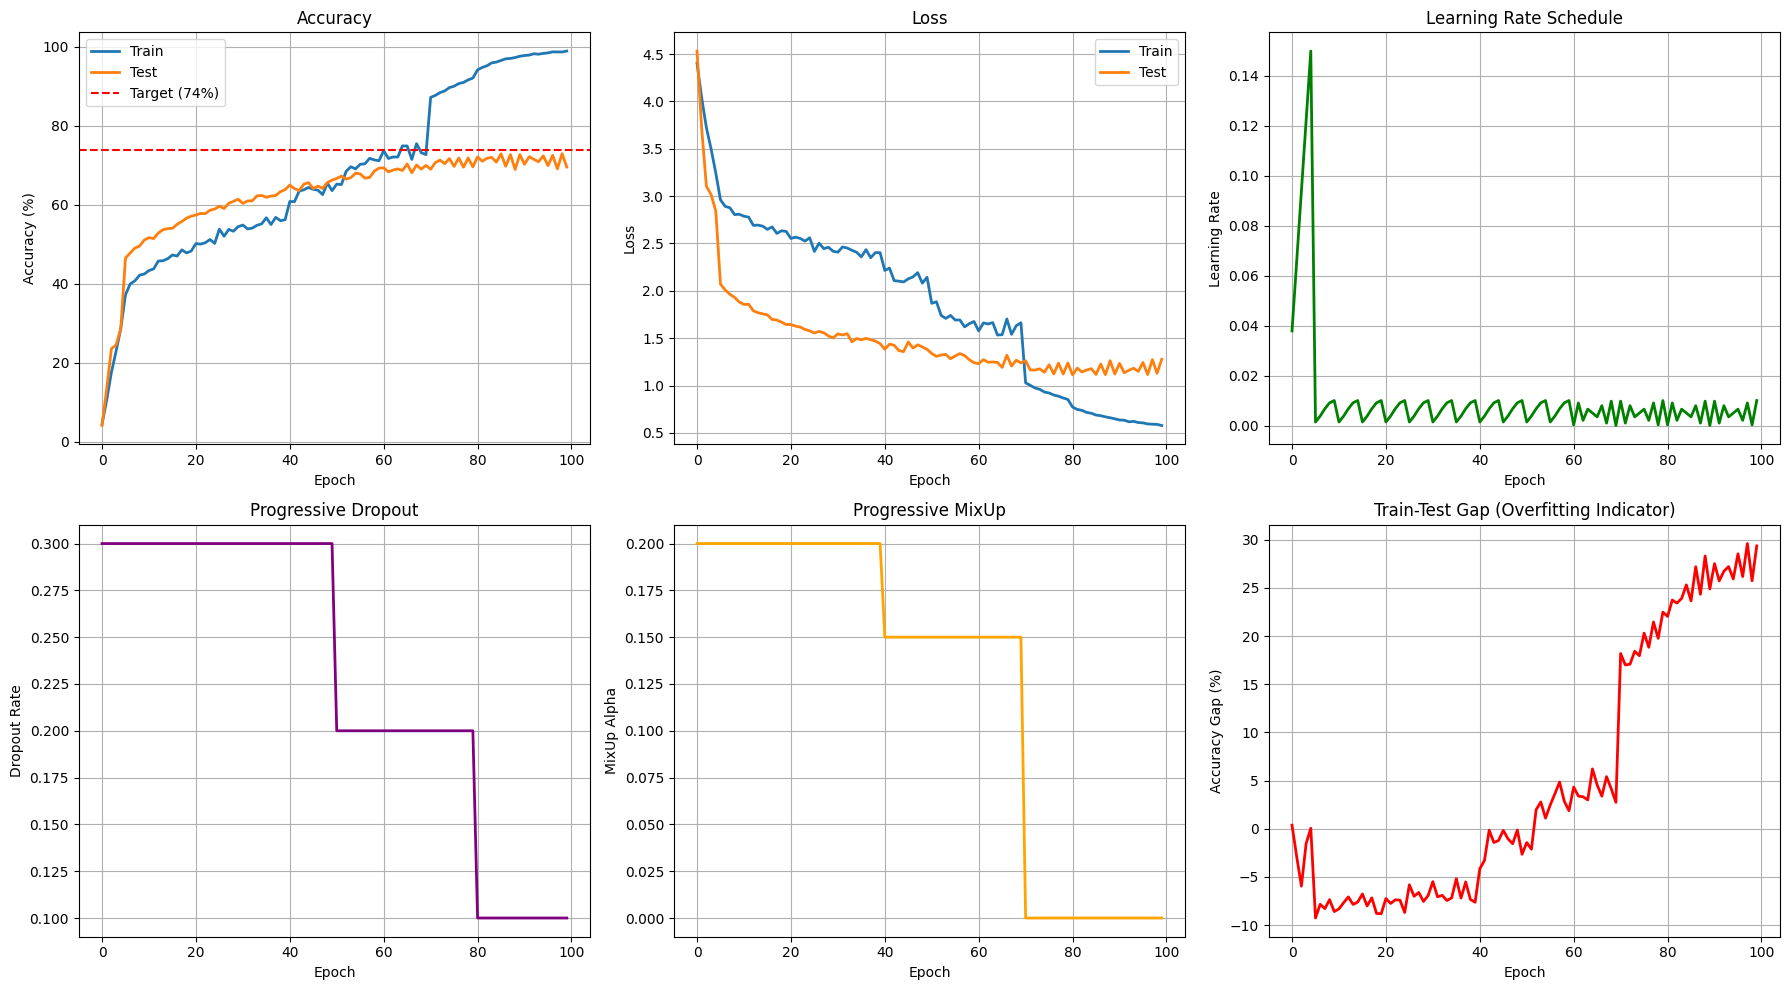

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...oints/training_curves.png:  91%|#########1|  558kB /  612kB            

  → Uploaded to HF: training_curves.png

Final Statistics:
Best Test Accuracy: 72.98%
Final Train Accuracy: 98.96%
Final Test Accuracy: 69.59%
Final Train-Test Gap: 29.37%

Google Drive checkpoints: 6 files


In [13]:
# Plot Training Curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].plot(train_accuracies, label='Train', linewidth=2)
axes[0, 0].plot(test_accuracies, label='Test', linewidth=2)
axes[0, 0].axhline(y=74, color='r', linestyle='--', label='Target (74%)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(train_losses, label='Train', linewidth=2)
axes[0, 1].plot(test_losses, label='Test', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning Rate
axes[0, 2].plot(learning_rates, linewidth=2, color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Learning Rate')
axes[0, 2].set_title('Learning Rate Schedule')
axes[0, 2].grid(True)

# Dropout History
axes[1, 0].plot(dropout_history, linewidth=2, color='purple')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dropout Rate')
axes[1, 0].set_title('Progressive Dropout')
axes[1, 0].grid(True)

# MixUp History
axes[1, 1].plot(mixup_history, linewidth=2, color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MixUp Alpha')
axes[1, 1].set_title('Progressive MixUp')
axes[1, 1].grid(True)

# Train-Test Gap
accuracy_gap = [train - test for train, test in zip(train_accuracies, test_accuracies)]
axes[1, 2].plot(accuracy_gap, linewidth=2, color='red')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy Gap (%)')
axes[1, 2].set_title('Train-Test Gap (Overfitting Indicator)')
axes[1, 2].grid(True)

plt.tight_layout()
curves_path = os.path.join(checkpoint_dir, 'training_curves.png')
plt.savefig(curves_path, dpi=300, bbox_inches='tight')
plt.show()

upload_to_huggingface(curves_path, 'training_curves.png', "Training curves")

print(f"\nFinal Statistics:")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")
print(f"\nGoogle Drive checkpoints: {len(gdrive_manager.list_checkpoints())} files")

In [14]:
# Load best model and final evaluation
best_checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
model.load_state_dict(best_checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")
print(f"Best test accuracy: {best_checkpoint['test_accuracy']:.2f}%")

test_loss, test_acc = test(model, device, test_loader)
print(f"\nFinal evaluation: {test_acc:.2f}%")

Loaded best model from epoch 99
Best test accuracy: 72.98%

Test set: Average loss: 1.1294, Accuracy: 7298/10000 (72.98%)


Final evaluation: 72.98%
